<a href="https://colab.research.google.com/github/aleks-haksly/VIZRO/blob/main/demos/test_yandex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install vizro -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.0/857.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.8/500.8 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 10.8 MB/s eta 0:00:00


In [ ]:
pd.DataFrame({"Actual": [100, 200, 700], "Reference": [100, 300, 500], "Category": ["A", "B", "C"]})

,Actual,Reference,Category
0,100,100,A
1,200,300,B
2,700,500,C


In [ ]:
!git clone https://github.com/andron23/yandex-data.git

Cloning into 'yandex-data'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), 17.10 MiB | 37.57 MiB/s, done.


In [ ]:
!pip install dash -q

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
 px.data.tips()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [1]:
#!pip install prophet --quiet
from prophet import Prophet

In [2]:
from sqlalchemy import text
from sqlalchemy import create_engine
import pandas as pd
from google.colab import userdata


engine = create_engine(userdata.get("supabase"), client_encoding='utf8', )

def select(sql):
    sql = text(sql)
    return pd.read_sql(sql, engine.connect())
data = select("SELECT ds, count as y, platform FROM vizro.yandex_data_agg")

In [3]:
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False, interval_width=0.95)

In [7]:
def make_forecast(
    df, freq='h', platform='desktop', periods=0, daily_seasonality=True,
    weekly_seasonality=True, yearly_seasonality=False, interval_width=0.95
):
    """
    Generate a forecast using the Prophet library for a specified platform and frequency.
    """
    filtered_df = (
        df.query("scale == 'hours' & platform == @platform")
          [['ds', 'count']]
          .rename(columns={'count': 'y'})
          .reset_index(drop=True)
    )
    model = Prophet(
        daily_seasonality=daily_seasonality,
        weekly_seasonality=weekly_seasonality,
        yearly_seasonality=yearly_seasonality,
        interval_width=interval_width
    )
    model.fit(filtered_df)
    future = model.make_future_dataframe(freq=freq, periods=periods)
    forecast = model.predict(future)

    # Add historical values and ensure no negative predictions
    forecast['y'] = filtered_df['y']
    for col in ['yhat', 'yhat_lower']:
        forecast[col] = forecast[col].clip(lower=0.0)

    return forecast




In [4]:
import numpy as np

In [5]:
df = data.query("platform=='desktop'").reset_index()
model.fit(df)
future = model.make_future_dataframe(freq='h', periods=0)
forecast = model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bjbethz/30yihj6l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4bjbethz/9rv25c9w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8753', 'data', 'file=/tmp/tmp4bjbethz/30yihj6l.json', 'init=/tmp/tmp4bjbethz/9rv25c9w.json', 'output', 'file=/tmp/tmp4bjbethz/prophet_modelndbyncx_/prophet_model-20250111232115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:21:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:21:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [11]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-08-30 00:00:00,10485.668736,4649.755683,39276.736724,10485.668736,10485.668736,12330.859028,12330.859028,12330.859028,8114.235890,8114.235890,8114.235890,4216.623137,4216.623137,4216.623137,0.0,0.0,0.0,22816.527764
1,2021-09-01 00:00:00,5555.429720,-6127.372941,30039.392048,5555.429720,5555.429720,7201.900672,7201.900672,7201.900672,8114.235890,8114.235890,8114.235890,-912.335219,-912.335219,-912.335219,0.0,0.0,0.0,12757.330391
2,2021-09-01 01:00:00,5452.716407,-6670.448501,28878.337048,5452.716407,5452.716407,4999.034563,4999.034563,4999.034563,5845.833657,5845.833657,5845.833657,-846.799094,-846.799094,-846.799094,0.0,0.0,0.0,10451.750970
3,2021-09-01 02:00:00,5350.003094,-13275.348041,25033.560731,5350.003094,5350.003094,299.467602,299.467602,299.467602,1083.735538,1083.735538,1083.735538,-784.267936,-784.267936,-784.267936,0.0,0.0,0.0,5649.470696
4,2021-09-01 03:00:00,5247.289781,-15648.526665,20458.036323,5247.289781,5247.289781,-3661.895751,-3661.895751,-3661.895751,-2935.985521,-2935.985521,-2935.985521,-725.910230,-725.910230,-725.910230,0.0,0.0,0.0,1585.394030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,2021-09-21 19:00:00,1386.067699,-18895.851143,17353.397669,1386.067699,1386.067699,-2475.408653,-2475.408653,-2475.408653,-1237.109891,-1237.109891,-1237.109891,-1238.298762,-1238.298762,-1238.298762,0.0,0.0,0.0,-1089.340955
501,2021-09-21 20:00:00,1384.567686,-20241.506335,14659.671402,1384.567686,1384.567686,-3929.988219,-3929.988219,-3929.988219,-2751.893989,-2751.893989,-2751.893989,-1178.094231,-1178.094231,-1178.094231,0.0,0.0,0.0,-2545.420533
502,2021-09-21 21:00:00,1383.067673,-20805.639879,16314.849507,1383.067673,1383.067673,-2915.891147,-2915.891147,-2915.891147,-1801.965848,-1801.965848,-1801.965848,-1113.925299,-1113.925299,-1113.925299,0.0,0.0,0.0,-1532.823474
503,2021-09-21 22:00:00,1381.567660,-16568.010942,20409.648709,1381.567660,1381.567660,927.773165,927.773165,927.773165,1975.051104,1975.051104,1975.051104,-1047.277938,-1047.277938,-1047.277938,0.0,0.0,0.0,2309.340825


In [9]:
n_predictions = 24

In [10]:
MAE = round(np.mean(abs(np.asarray(forecast['yhat']) - np.asarray(df['y'][-n_predictions:]))))
MAE_p = round(np.mean((abs(np.asarray(forecast['yhat']) - np.asarray(['y'])) / abs(np.asarray(df['y']))*100)[-n_predictions:]), 2)
print(f'MAE: {MAE}')
print(f'MAE %: {MAE_p}')

ValueError: operands could not be broadcast together with shapes (505,) (24,) 

In [7]:
529 - 505

24

In [10]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

In [ ]:
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

array(['desktop', 'touch'], dtype=object)

In [ ]:
data.sort_values(by="ds")

,ds,count,y
130,2021-09-01 00:00:00,360,desktop
340,2021-09-01 00:00:00,987,touch
624,2021-09-01 01:00:00,675,touch
572,2021-09-01 01:00:00,191,desktop
524,2021-09-01 02:00:00,635,touch
...,...,...,...
292,2021-09-21 21:00:00,2418,touch
595,2021-09-21 22:00:00,1954,touch
134,2021-09-21 22:00:00,1013,desktop
596,2021-09-21 23:00:00,1193,touch


In [ ]:

model.fit(d);

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4c_w84_5/3dy79fdz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4c_w84_5/95so_a98.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41662', 'data', 'file=/tmp/tmp4c_w84_5/3dy79fdz.json', 'init=/tmp/tmp4c_w84_5/95so_a98.json', 'output', 'file=/tmp/tmp4c_w84_5/prophet_modelp7c_9ykk/prophet_model-20250101082400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:24:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:24:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


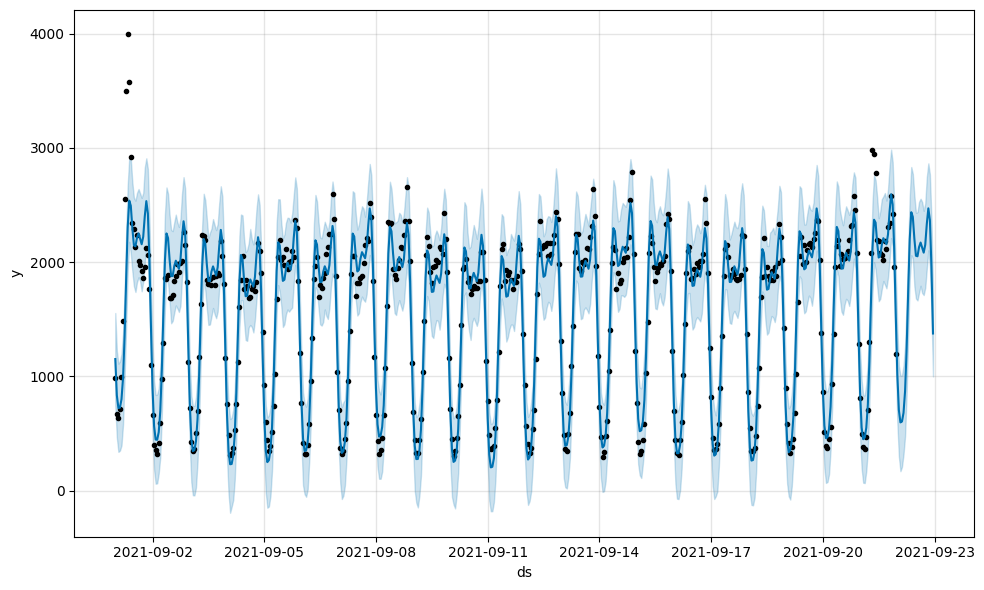

In [ ]:
future = model.make_future_dataframe(freq='h', periods=24)
forecast = model.predict(future)
model.plot(forecast);

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-09-01 00:00:00,1769.659759,745.145332,1555.065208,1769.659759,1769.659759,-617.337573,-617.337573,-617.337573,-790.273090,-790.273090,-790.273090,172.935517,172.935517,172.935517,0.0,0.0,0.0,1152.322186
1,2021-09-01 01:00:00,1766.667492,465.143502,1224.758907,1766.667492,1766.667492,-931.482662,-931.482662,-931.482662,-1104.626367,-1104.626367,-1104.626367,173.143705,173.143705,173.143705,0.0,0.0,0.0,835.184830
2,2021-09-01 02:00:00,1763.675225,340.020614,1112.147947,1763.675225,1763.675225,-1040.153865,-1040.153865,-1040.153865,-1212.543669,-1212.543669,-1212.543669,172.389804,172.389804,172.389804,0.0,0.0,0.0,723.521360
3,2021-09-01 03:00:00,1760.682958,351.507958,1131.744329,1760.682958,1760.682958,-1032.798224,-1032.798224,-1032.798224,-1203.464279,-1203.464279,-1203.464279,170.666054,170.666054,170.666054,0.0,0.0,0.0,727.884734
4,2021-09-01 04:00:00,1757.690691,396.842735,1196.512013,1757.690691,1757.690691,-957.336910,-957.336910,-957.336910,-1125.311554,-1125.311554,-1125.311554,167.974644,167.974644,167.974644,0.0,0.0,0.0,800.353781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,2021-09-22 19:00:00,1646.084306,1941.483551,2743.280320,1641.292471,1650.657017,687.953937,687.953937,687.953937,647.790617,647.790617,647.790617,40.163320,40.163320,40.163320,0.0,0.0,0.0,2334.038243
524,2021-09-22 20:00:00,1646.547054,2103.722846,2864.778592,1641.472936,1651.554247,824.488417,824.488417,824.488417,795.421237,795.421237,795.421237,29.067180,29.067180,29.067180,0.0,0.0,0.0,2471.035471
525,2021-09-22 21:00:00,1647.009802,1966.376985,2767.481279,1641.366646,1652.294640,720.789068,720.789068,720.789068,702.648025,702.648025,702.648025,18.141043,18.141043,18.141043,0.0,0.0,0.0,2367.798869
526,2021-09-22 22:00:00,1647.472550,1583.274025,2370.701494,1641.523764,1653.109756,311.760096,311.760096,311.760096,304.290280,304.290280,304.290280,7.469816,7.469816,7.469816,0.0,0.0,0.0,1959.232645


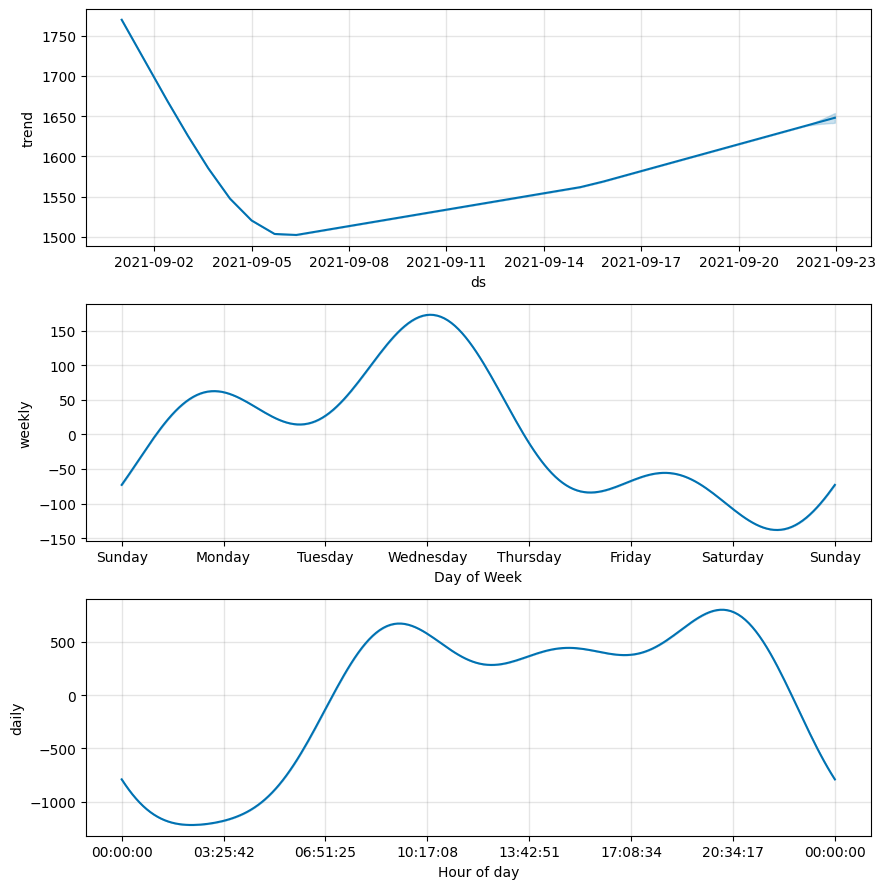

In [ ]:
model.plot_components(forecast);

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-09-01 00:00:00,1769.659759,745.145332,1555.065208,1769.659759,1769.659759,-617.337573,-617.337573,-617.337573,-790.273090,-790.273090,-790.273090,172.935517,172.935517,172.935517,0.0,0.0,0.0,1152.322186
1,2021-09-01 01:00:00,1766.667492,465.143502,1224.758907,1766.667492,1766.667492,-931.482662,-931.482662,-931.482662,-1104.626367,-1104.626367,-1104.626367,173.143705,173.143705,173.143705,0.0,0.0,0.0,835.184830
2,2021-09-01 02:00:00,1763.675225,340.020614,1112.147947,1763.675225,1763.675225,-1040.153865,-1040.153865,-1040.153865,-1212.543669,-1212.543669,-1212.543669,172.389804,172.389804,172.389804,0.0,0.0,0.0,723.521360
3,2021-09-01 03:00:00,1760.682958,351.507958,1131.744329,1760.682958,1760.682958,-1032.798224,-1032.798224,-1032.798224,-1203.464279,-1203.464279,-1203.464279,170.666054,170.666054,170.666054,0.0,0.0,0.0,727.884734
4,2021-09-01 04:00:00,1757.690691,396.842735,1196.512013,1757.690691,1757.690691,-957.336910,-957.336910,-957.336910,-1125.311554,-1125.311554,-1125.311554,167.974644,167.974644,167.974644,0.0,0.0,0.0,800.353781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,2021-09-22 19:00:00,1646.084306,1941.483551,2743.280320,1641.292471,1650.657017,687.953937,687.953937,687.953937,647.790617,647.790617,647.790617,40.163320,40.163320,40.163320,0.0,0.0,0.0,2334.038243
524,2021-09-22 20:00:00,1646.547054,2103.722846,2864.778592,1641.472936,1651.554247,824.488417,824.488417,824.488417,795.421237,795.421237,795.421237,29.067180,29.067180,29.067180,0.0,0.0,0.0,2471.035471
525,2021-09-22 21:00:00,1647.009802,1966.376985,2767.481279,1641.366646,1652.294640,720.789068,720.789068,720.789068,702.648025,702.648025,702.648025,18.141043,18.141043,18.141043,0.0,0.0,0.0,2367.798869
526,2021-09-22 22:00:00,1647.472550,1583.274025,2370.701494,1641.523764,1653.109756,311.760096,311.760096,311.760096,304.290280,304.290280,304.290280,7.469816,7.469816,7.469816,0.0,0.0,0.0,1959.232645


In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-09-01,54711.201363,57768.239831,63076.683915,54711.201363,54711.201363,5785.823323,5785.823323,5785.823323,5785.823323,5785.823323,5785.823323,0.0,0.0,0.0,60497.024686
1,2021-09-02,54971.200986,52533.534233,57613.997134,54971.200986,54971.200986,163.282274,163.282274,163.282274,163.282274,163.282274,163.282274,0.0,0.0,0.0,55134.483259
2,2021-09-03,55231.200610,50208.436314,55148.853086,55231.200610,55231.200610,-2493.884063,-2493.884063,-2493.884063,-2493.884063,-2493.884063,-2493.884063,0.0,0.0,0.0,52737.316547
3,2021-09-04,55491.200233,45358.972305,50516.293388,55491.200233,55491.200233,-7426.542537,-7426.542537,-7426.542537,-7426.542537,-7426.542537,-7426.542537,0.0,0.0,0.0,48064.657696
4,2021-09-05,55751.199856,51516.082145,56474.601254,55751.199856,55751.199856,-1774.779269,-1774.779269,-1774.779269,-1774.779269,-1774.779269,-1774.779269,0.0,0.0,0.0,53976.420588
5,2021-09-06,56011.201078,56005.208567,60924.614166,56011.201078,56011.201078,2424.875521,2424.875521,2424.875521,2424.875521,2424.875521,2424.875521,0.0,0.0,0.0,58436.076599
6,2021-09-07,56271.509394,57103.903335,62157.138980,56271.509394,56271.509394,3321.224751,3321.224751,3321.224751,3321.224751,3321.224751,3321.224751,0.0,0.0,0.0,59592.734146
7,2021-09-08,56532.000357,59805.154846,64890.105988,56532.000357,56532.000357,5785.823323,5785.823323,5785.823323,5785.823323,5785.823323,5785.823323,0.0,0.0,0.0,62317.823680
8,2021-09-09,56792.507608,54405.711099,59475.876858,56792.507608,56792.507608,163.282274,163.282274,163.282274,163.282274,163.282274,163.282274,0.0,0.0,0.0,56955.789881
9,2021-09-10,57053.024215,51959.595120,57031.637779,57053.024215,57053.024215,-2493.884063,-2493.884063,-2493.884063,-2493.884063,-2493.884063,-2493.884063,0.0,0.0,0.0,54559.140152


In [ ]:
from etna.datasets import TSDataset

/usr/local/lib/python3.10/dist-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:62: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("etna[classification] is not available, to install it, run `pip install etna[classification]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:71: UserWarning: etna[auto] is not available, to install it, run `pip install etna[auto]`
  warnings.warn("etna[auto] is not available, to install it, run `pip install etna[auto]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:79: UserWarning: etna[statsforecast] is not available, to install it, run `pip install etna[statsforecast]`
  warnings.warn("etna[statsforecast] is not available, to install it, run 

In [ ]:
d["date"] = pd.to_datetime(d["date"], format='%Y-%m-%d')
df_day = d.groupby("date", as_index=False)["count"].sum().rename(columns={"date":"timestamp", "count": "target"})
df_day["segment"] = 'main'
df_day = TSDataset(TSDataset.to_dataset(df_day), freq='D')

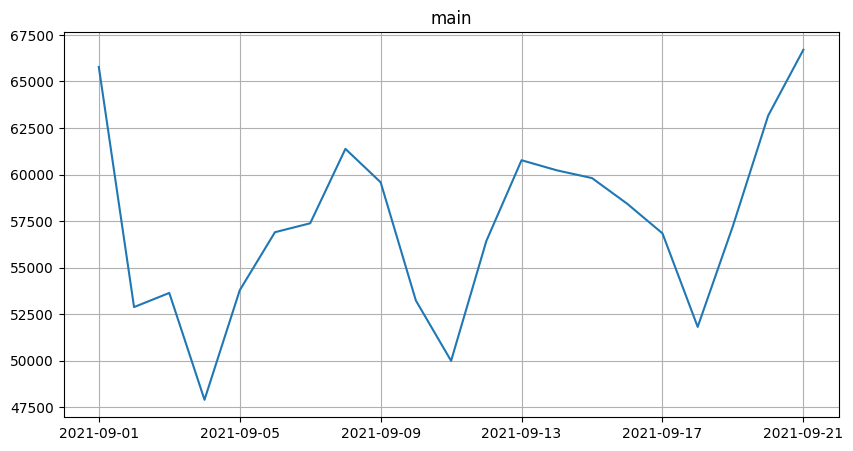

In [ ]:
df_day.plot()

In [ ]:
anomalies_model

{}

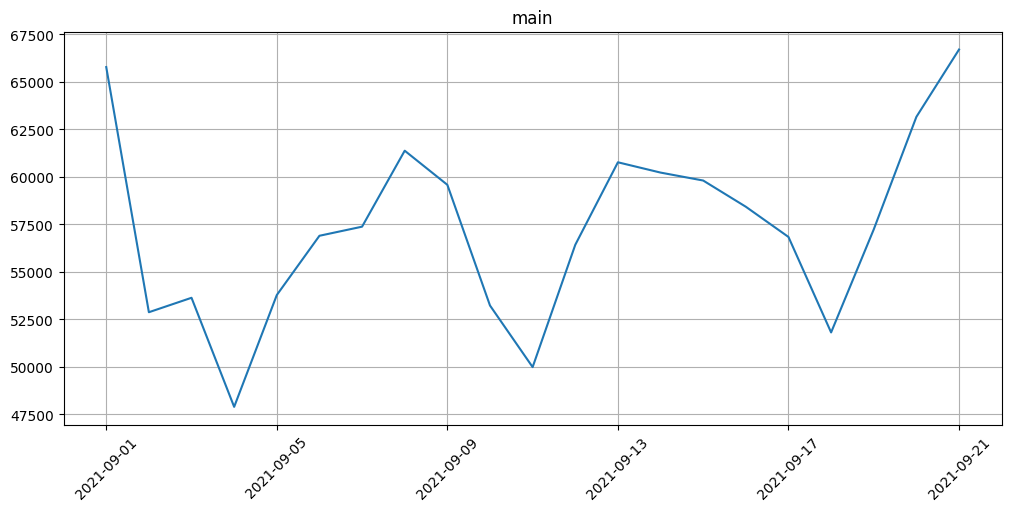

In [ ]:
anomalies_model = get_anomalies_median(
    df_day, window_size =4,
)

plot_anomalies(df_day, anomalies_model)

In [ ]:
def get_kpi_data(data=df, platform="touch", scale="day"):
        match scale:
            case 'day':
                d = df.groupby(["platform", "date"], as_index=False)["count"].sum().rename(columns={"count": "actual"})
                d["previous"] = d["actual"].shift(1)
                return d.query("platform==@platform").tail(1)
            case 'hour':
                d = df.groupby(["platform", "date", "hour"], as_index=False)["count"].sum().rename(columns={"count": "actual"})
                d["previous"] = d["actual"].shift(1)
                return d.query("platform==@platform").tail(1)

In [ ]:
get_kpi_data(platform="desktop", scale="day")

,platform,date,actual,previous
20,desktop,2021-09-21,23756,23913.0


# Подготовка данных

## Читаем json в архиве zip

In [ ]:
df = pd.read_json('/content/yandex-data/data.zip', compression='zip')

## Преобразуем поле с датой в формате datetime


In [ ]:
df["ts"] = pd.to_datetime(df["ts"], unit='s')

In [ ]:
# Видим, что до полных суток нехватает 3 часов, исправляем часовой пояс tz
df["ts"].min(), df["ts"].max()

(Timestamp('2021-08-31 21:00:00'), Timestamp('2021-09-21 20:59:59'))

In [ ]:
df["ts"] = df["ts"] + pd.Timedelta(hours=3)
df["ts"].min(), df["ts"].max()

(Timestamp('2021-09-01 00:00:00'), Timestamp('2021-09-21 23:59:59'))

## Создаем новые признаки:
- дата
- день недели
- час
- выходной

In [ ]:
df["date"] = df["ts"].dt.date
df["weekday"] = df["ts"].dt.day_name()
df["hour"] = df["ts"].dt.hour
df["weekend"] = df["weekday"].isin(['Saturday', 'Sunday'])

## Преобразуем текст запросов к нижнему регистру

In [ ]:
df['query'] = df['query'].str.lower()

# Анализ данных

## 1 График распределения количества запросов по дням

In [ ]:
plot_data = df.groupby(["platform", "date", "weekday", "weekend"], as_index=False)['ts'].count()
fig = px.line(plot_data, x='date', y='ts',  color="platform", title="Количество запросов на разных платформах по дням", hover_data="weekday")


# Добавляем области заливки для выходных
weekend_ranges = []
weekend_data = plot_data[plot_data["weekend"] == True]

# Определяем интервалы выходных
for date in weekend_data["date"]:
    weekend_ranges.append((date, date + pd.Timedelta(days=1)))

weekend_fillcolor="rgba(128, 0, 128, 0.2)" # заливка для выходных

for start, end in weekend_ranges:
    fig.add_shape(
        type="rect",
        x0=start,
        x1=end,
        y0=0,
        y1=max(plot_data["ts"]),
        fillcolor=weekend_fillcolor,
        layer="below",
        line_width=0
    )
fig.add_trace(go.Scatter(
    x=[None],  # Фиктивные данные
    y=[None],
    mode="markers",
    marker=dict(size=10, color=weekend_fillcolor),  # Цвет совпадает с заливкой
    name="weekend"
))

fig.show()

### На графике выше наблюдается сезонность, выраженная в просадке по количеству поисковых запросов с платформы desktop в субботу

## Приведем строки к нижнему регистру

## 2 TOP 10 самых популярных запросов с разбивкой по платформам

In [ ]:
df.groupby(["platform", "query"], as_index=False)["ts"].\
   count().\
   sort_values(by=["ts"], ascending=False).\
   groupby("platform").head(10).\
   sort_values(by=["platform", "ts"], ascending=False)

,platform,query,ts
37935,touch,порно,10076
40961,touch,секс,8262
40234,touch,с днём рождения женщине,4924
44810,touch,хентай,4194
40168,touch,с днём рождения,4123
40319,touch,с днём рождения мужчине,3669
40018,touch,с днем рождения,3315
24242,touch,xxx,3249
24227,touch,xnxx,2767
28865,touch,доброе утро,2342


## 3 Соотношение количества запросов по платформам

In [ ]:
platform_distribution = df['platform'].value_counts(normalize=True).reset_index()
px.pie(platform_distribution, values='proportion', names='platform', title='Соотношение количества запросов <br>             по платформам', width=400, height=400)

## 4 Распределение активности пользователей в течение суток

In [ ]:
px.bar(df.groupby(["platform", "weekend", 'hour'], as_index=False).size(), x="hour", y="size", color='platform', title='Распределение запросов по времени суток в будние дни и выходные', barmode="group", facet_row="weekend")

## 5 Топ популярных запросов по платформам и времени суток

In [ ]:
popular_queries = set(df.groupby(["hour", "query"], as_index=False)["platform"]
                      .count()
                      .sort_values(by="platform", ascending=False)
                      .groupby("hour")
                      .head(5)["query"]
                      .tolist())

In [ ]:
popular_queries

{'porno',
 'sex',
 'xxx',
 'айфон 13',
 'английский алфавит',
 'доброе утро',
 'доброе утро картинки',
 'календарь 2021',
 'картинки',
 'порно',
 'с днем рождения',
 'с днём рождения',
 'с днём рождения женщине',
 'с днём рождения мужчине',
 'секс',
 'таблица менделеева',
 'хентай'}

## 6 Изменение популярности запросов по времени суток на разных платформах

In [ ]:
px.line(

        df[df["query"].isin(popular_queries)].\
        groupby(["platform", "query", "hour"], as_index=False)["ts"].count(),
        x = 'hour',
        y = 'ts',
        color='query',
        facet_col="platform"

)

## 7 Доли популярных запросов в общем числе запросов на платформах

In [ ]:
# Подсчет количества запросов по платформам и запросам
query_counts =  df[df["query"].isin(popular_queries)].groupby(['platform', 'query']).size().reset_index(name='count')

# Подсчет общего количества запросов для каждой платформы
platform_totals = df.groupby('platform')['query'].count().reset_index(name='total')

# Добавление долей
query_counts = query_counts.merge(platform_totals, on='platform')
query_counts['share'] = (query_counts['count'] / query_counts['total']).astype("float")
query_counts['share %'] = query_counts['share'].apply(lambda x: f"{x:.2%}")

pivot_table = query_counts.pivot(index="query", columns="platform", values=["count", "share %", "share"]).sort_values(by=(  'count',   'touch'), ascending=False)
pivot_table.iloc[:,:-2]

count        share %       
platform                desktop  touch desktop  touch
query                                                
порно                      1408  10076   0.34%  1.27%
секс                        947   8262   0.23%  1.04%
с днём рождения женщине     503   4924   0.12%  0.62%
хентай                      821   4194   0.20%  0.53%
с днём рождения             297   4123   0.07%  0.52%
с днём рождения мужчине     332   3669   0.08%  0.46%
с днем рождения             454   3315   0.11%  0.42%
xxx                         261   3249   0.06%  0.41%
доброе утро                 145   2342   0.04%  0.30%
таблица менделеева         2659   2278   0.65%  0.29%
календарь 2021             2810   2268   0.68%  0.29%
porno                       347   2234   0.08%  0.28%
sex                         234   2000   0.06%  0.25%
айфон 13                    393   1846   0.10%  0.23%
картинки                   1720   1801   0.42%  0.23%
английский алфавит         1352   1749   0.33%  0.22%
доброе утро картинки        113   1672   0.03%  0.21%

In [ ]:
df

,query,ts,platform,date,weekday,hour,weekend
0,порно фото,2021-09-16 13:04:57,touch,2021-09-16,Thursday,13,False
1,малевич картины,2021-09-16 18:34:25,desktop,2021-09-16,Thursday,18,False
2,секс,2021-09-16 11:39:43,touch,2021-09-16,Thursday,11,False
3,с днём рождения лена,2021-09-16 08:52:43,touch,2021-09-16,Thursday,8,False
4,зверополис порно,2021-09-16 13:19:59,touch,2021-09-16,Thursday,13,False
...,...,...,...,...,...,...,...
1203819,бабочка,2021-09-12 22:40:53,touch,2021-09-12,Sunday,22,True
1203820,все республики россии,2021-09-12 19:08:54,touch,2021-09-12,Sunday,19,True
1203821,кухня в стиле лофт,2021-09-12 10:37:32,touch,2021-09-12,Sunday,10,True
1203822,топор,2021-09-12 15:22:27,desktop,2021-09-12,Sunday,15,True


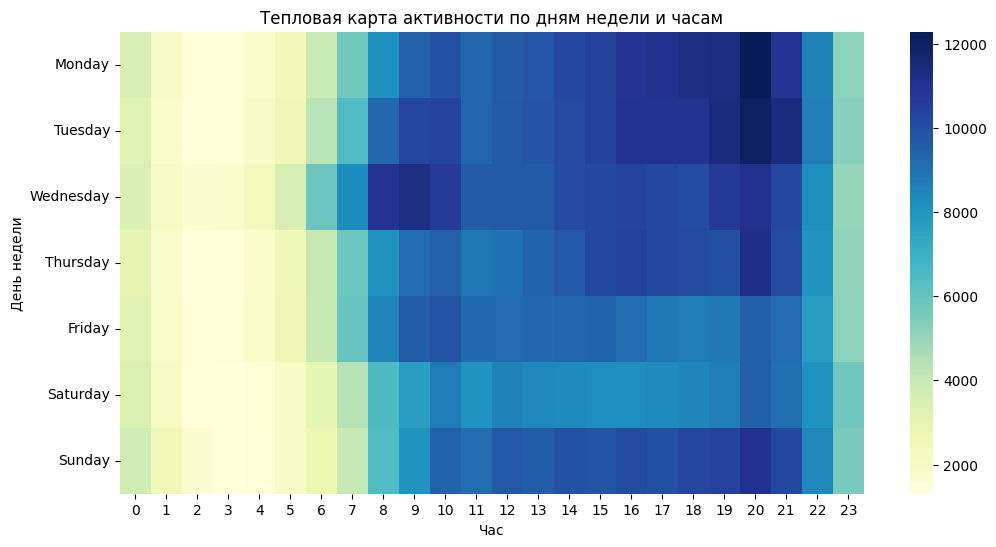

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

# Порядок дней недели (если нужен стандартный порядок)
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

# Построение тепловой карты
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt="d")
plt.title('Тепловая карта активности по дням недели и часам')
plt.xlabel('Час')
plt.ylabel('День недели')
plt.show()


In [ ]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

app = Dash(__name__)


# Описание интерфейса
app.layout = html.Div([
    html.H4('Запросы на платформах'),
    dcc.Graph(id="graph"),
    html.P("Выберите платформы:"),
    dcc.Checklist(
        id='platform',
        options=[{"label": "Desktop", "value": "desktop"},
                 {"label": "Touch", "value": "touch"}],
        value=["desktop", "touch"],  # Значения по умолчанию
        inline=True
    ),
])

# Callback для обновления графика
@app.callback(
    Output("graph", "figure"),
    Input("platform", "value"))
def filter_heatmap(platforms):
    # Фильтруем данные по выбранным платформам
    filtered_df = df[df["platform"].isin(platforms)]

    # Группируем данные для тепловой карты (пример)
    heatmap_data = filtered_df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)
    ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    heatmap_data = heatmap_data.reindex(ordered_days)
    # Создаем тепловую карту
    fig = px.imshow(
        heatmap_data,
        labels=dict(x="Время", y="День недели", color="Количество запросов"),
        title="Распределение запросов по дням недели и времени", text_auto=True
    )
    return fig

# Запуск сервера
app.run_server(debug=True)

<IPython.core.display.Javascript object>

In [ ]:
heatmap_data.sort_index()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
Friday,3218,1872,1402,1456,1862,2571,4034,5950,8452,9580,...,9317,9406,9127,8827,8748,8812,9490,9153,7721,5185
Monday,3504,1974,1460,1378,1816,2490,3953,5736,8152,9417,...,10249,10458,10946,11046,11262,11325,12281,10949,8576,5203
Saturday,3352,2094,1416,1340,1487,1966,2989,4393,6513,7765,...,8306,8224,8234,8348,8445,8645,9486,9063,8054,5808
Sunday,3807,2423,1687,1308,1442,1912,2726,4072,6480,8073,...,9915,9834,10123,9956,10296,10405,11069,10201,8402,5563
Thursday,2975,1828,1384,1320,1764,2537,4063,5870,8086,9137,...,9728,10257,10449,10236,10099,10014,11139,10119,8062,5138
Tuesday,3206,1895,1359,1409,1917,2591,4340,6481,9273,10288,...,10108,10473,10998,11014,10999,11396,12037,11394,8674,5285
Wednesday,3386,2084,1676,1807,2352,3455,5811,8277,10945,11276,...,10154,10262,10392,10234,10056,10732,11093,10237,8175,5003


In [ ]:
px.bar(pivot_table["share"].map(lambda x: float(x)).reset_index(), x="query", y=["desktop", "touch"] , barmode="group", labels=[1, 2])

In [ ]:
pivot_df = pd.pivot_table(data=df, index='query', columns='platform', values='ts', aggfunc='count', fill_value=0, margins=True).sort_values(by="All", ascending=False).query("All > 15")

In [ ]:
pivot_df["desktop_%"] = pivot_df.desktop / pivot_df.desktop.iloc[0] * 100
pivot_df["touch_%"] = pivot_df.touch / pivot_df.touch.iloc[0] * 100
pivot_df["%_diff"] = pivot_df["desktop_%"] - pivot_df["touch_%"]
pivot_df.reset_index(inplace=True)
pivot_df

platform,query,desktop,touch,All,desktop_%,touch_%,%_diff
0,All,411566,792258,1203824,100.000000,100.000000,0.000000
1,порно,1408,10076,11484,0.342108,1.271808,-0.929700
2,секс,947,8262,9209,0.230097,1.042842,-0.812745
3,с днём рождения женщине,503,4924,5427,0.122216,0.621515,-0.499299
4,календарь 2021,2810,2268,5078,0.682758,0.286270,0.396488
...,...,...,...,...,...,...,...
20374,клон,7,9,16,0.001701,0.001136,0.000565
20375,самсунг раскладушка,2,14,16,0.000486,0.001767,-0.001281
20376,узбекские женщины современные изменяют мужу,5,11,16,0.001215,0.001388,-0.000174
20377,алабай собака фото,3,13,16,0.000729,0.001641,-0.000912


In [ ]:
fig = px.box(data_frame=pivot_df, y="%_diff", boxmode="overlay", points='all')
fig.update_traces(boxpoints='all', boxmean=True, hovertemplate="Value: %{y}<br>Category: %{text}<extra></extra>",
    text=pivot_df["query"])
#fig.update_yaxes(title_text="x-axis in logarithmic scale", type="log")

In [ ]:
import plotly.express as px
import pandas as pd

# Пример данных
df = pd.DataFrame({
    "category": ["A", "A", "A", "A", "B", "B", "B", "B", "C", "C", "C", "C"],
    "value": [10, 15, 14, 100, 20, 25, 24, 300, 30, 35, 34, 500],
})

# Добавление hover текста для выбросов
fig = px.box(df, x="category", y="value")

# Настройка текста при наведении на выбросы
fig.update_traces(marker=dict(outliercolor='red'),
                  hoverinfo="text",
                  hovertext=["Outlier: {}".format(v) if v > 50 else None for v in df["value"]])

fig.show()


In [ ]:
df1 = (
    df
    .groupby(['platform', 'query'], as_index=False)
    ['ts']
    .agg({'count'})
    .pivot_table(
        index='query',
        columns='platform',
        values='count',
        fill_value=0
    )
    .sort_values('desktop', ascending=False)
)

df1['summa'] = df1['desktop'] + df1['touch']

df1 = df1[df1['summa'] > 15]

df1['desktop_rel'] = df1['desktop'] / max(df1['desktop'])
df1['touch_rel'] = df1['touch'] / max(df1['touch'])

df1['diff'] = df1['desktop']  - df1['touch']

df1

platform,desktop,touch,summa,desktop_rel,touch_rel,diff
query,,,,,,
календарь 2021,2810.0,2268.0,5078.0,1.000000,0.225089,542.0
таблица менделеева,2659.0,2278.0,4937.0,0.946263,0.226082,381.0
картинки,1720.0,1801.0,3521.0,0.612100,0.178742,-81.0
порно,1408.0,10076.0,11484.0,0.501068,1.000000,-8668.0
английский алфавит,1352.0,1749.0,3101.0,0.481139,0.173581,-397.0
...,...,...,...,...,...,...
опята ложные как отличить,0.0,24.0,24.0,0.000000,0.002382,-24.0
смешные картинки хорошего дня,0.0,37.0,37.0,0.000000,0.003672,-37.0
смешные картинки с добрым утром,0.0,21.0,21.0,0.000000,0.002084,-21.0


In [ ]:
px.box(df1, x='summa')

In [ ]:
px.box(df1, x='diff')

In [ ]:
import numpy as np

np.quantile(df1['diff'], 0.33), np.quantile(df1['diff'], 0.99)

(-16.0, 62.0)

In [ ]:
df1[(df1['diff'] > 35) | (df1['diff'] < -51)]

platform,desktop,touch,summa,desktop_rel,touch_rel,diff
query,,,,,,
календарь 2021,2810.0,2268.0,5078.0,1.000000,0.225089,542.0
таблица менделеева,2659.0,2278.0,4937.0,0.946263,0.226082,381.0
картинки,1720.0,1801.0,3521.0,0.612100,0.178742,-81.0
порно,1408.0,10076.0,11484.0,0.501068,1.000000,-8668.0
английский алфавит,1352.0,1749.0,3101.0,0.481139,0.173581,-397.0
...,...,...,...,...,...,...
открытки с днём знаний,0.0,57.0,57.0,0.000000,0.005657,-57.0
обои на телефон красивые,0.0,71.0,71.0,0.000000,0.007046,-71.0
онлайн казино,0.0,55.0,55.0,0.000000,0.005459,-55.0


In [ ]:
df2 = df1[(df1['diff'] > 35) | (df1['diff'] < -51)]

px.scatter(
    df2,
    x='desktop',
    y='touch'
)